# **Clasificación utilizando LightGBM (LGBM) (Core)**


**Objetivo**

Implementar un pipeline completo de machine learning para un problema de clasificación utilizando LightGBM (LGBM). Se hará especial énfasis en el Análisis Exploratorio de Datos (EDA), preprocesamiento, entrenamiento del modelo y optimización de hiperparámetros.

**Descripción del Dataset:** El dataset de predicción de préstamos contiene información sobre solicitantes de préstamos, como sus ingresos, historial crediticio y otras características personales. El objetivo es predecir si un solicitante será aprobado para un préstamo basándose en estos factores.

## **Parte 1: Carga y Exploración Inicial de Datos**

**Carga del Dataset:**

Cargar el dataset desde Kaggle.


Variable	Description

Loan_ID	Unique Loan ID

Gender	Male/ Female

Married	Applicant married (Y/N)

Dependents	Number of dependents

Education	Applicant Education (Graduate/ Under Graduate)

Self_Employed	Self employed (Y/N)

ApplicantIncome	Applicant income

CoapplicantIncome	Coapplicant income

LoanAmount	Loan amount in thousands

Loan_Amount_Term	Term of loan in months

Credit_History	credit history meets guidelines

Property_Area	Urban/ Semi Urban/ Rural

Loan_Status	Loan approved (Y/N)

In [ ]:
# Importamos las librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report

**Exploración Inicial:**

Revisar la estructura del dataset.
Describir las variables y su distribución.
Identificar y documentar valores faltantes y outliers.

In [24]:
# Cargamos el dataset
path = 'C:/Users/damav/Desktop/Codingdojo/clases/machine-learning/data/train.csv'
df = pd.read_csv(path)
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [25]:
# Identificar duplicados
duplicados = df.duplicated()
# Contar el número de duplicados
num_duplicados = duplicados.sum()
print(f"Número de registros duplicados: {num_duplicados}")

Número de registros duplicados: 0


In [26]:
# Información general
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [27]:
# Convertir las columnas a su tipo correspondiente
df['Loan_ID'] = df['Loan_ID'].astype(str)  # No change needed, but ensure it is string
df['Gender'] = df['Gender'].astype('category')
df['Married'] = df['Married'].astype('category')
df['Dependents'] = df['Dependents'].astype('category')
df['Education'] = df['Education'].astype('category')
df['Self_Employed'] = df['Self_Employed'].astype('category')
df['Property_Area'] = df['Property_Area'].astype('category')
df['Loan_Status'] = df['Loan_Status'].map({'Y': True, 'N': False}).astype('bool')

In [28]:
# Verificamos los valores faltantes
qsna=df.shape[0]-df.isnull().sum(axis=0)
qna=df.isnull().sum(axis=0)
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
Credit_History,564,50,8.14
Self_Employed,582,32,5.21
LoanAmount,592,22,3.58
Dependents,599,15,2.44
Loan_Amount_Term,600,14,2.28
Gender,601,13,2.12
Married,611,3,0.49
Education,614,0,0.00
Loan_ID,614,0,0.00
CoapplicantIncome,614,0,0.00


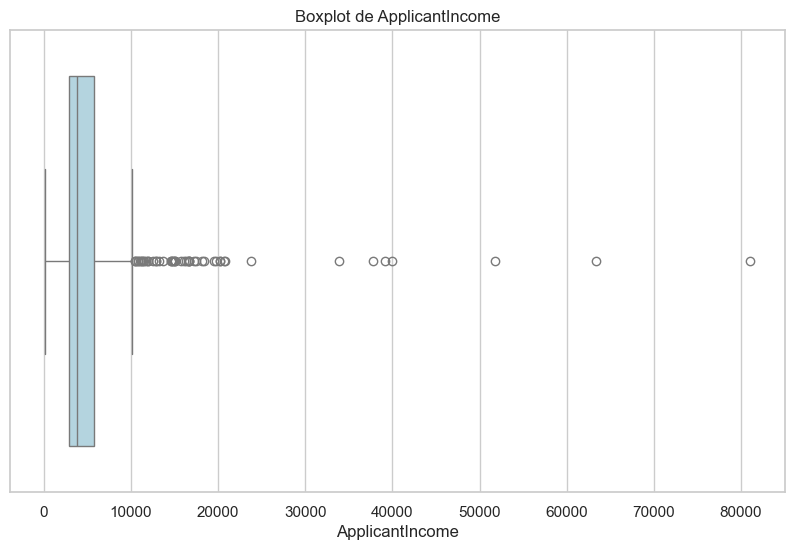

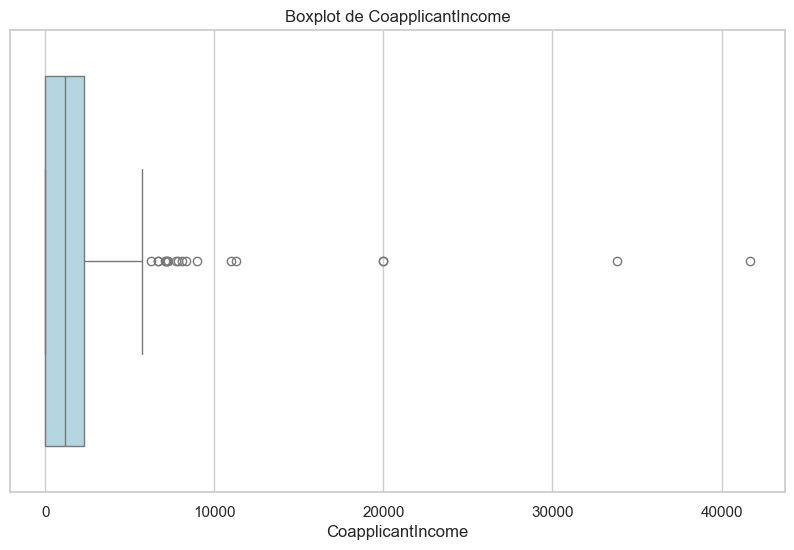

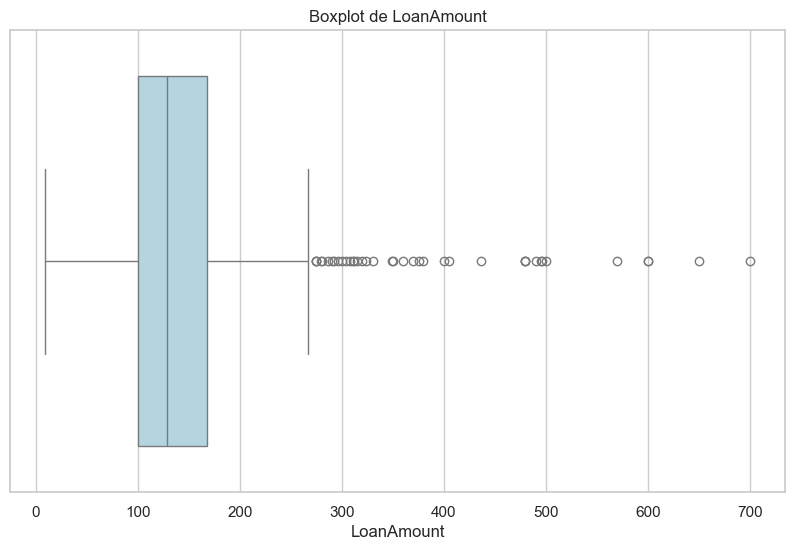

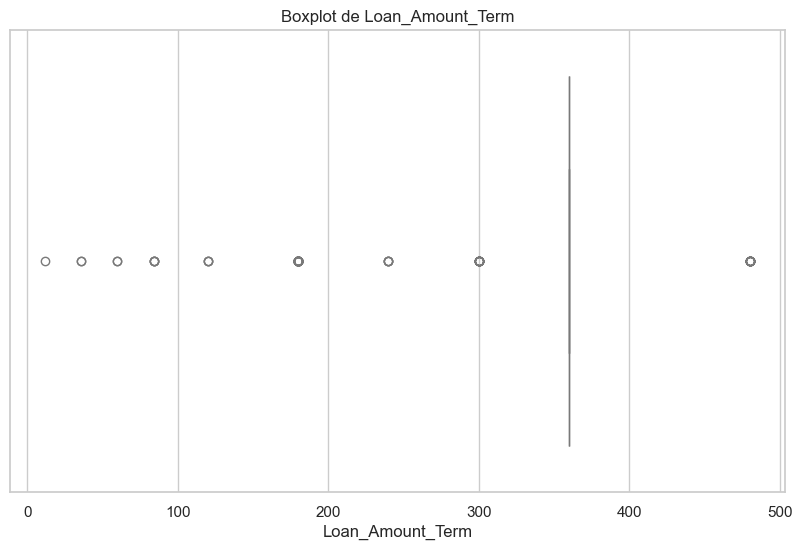

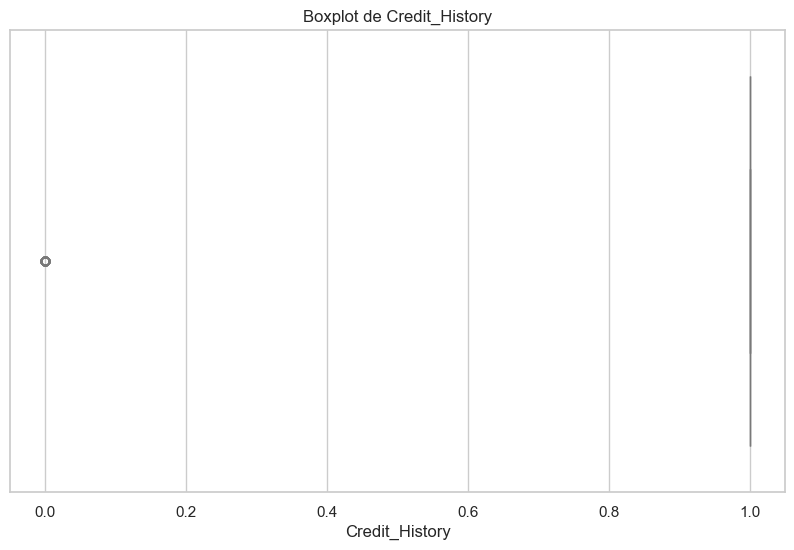

In [29]:
# Identificamos valores atípicos
sns.set(style="whitegrid")

# List of numerical columns
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# Create boxplots for each numerical column
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col], color='lightblue')
    plt.title(f'Boxplot de {col}')
    plt.xlabel(col)
    plt.show()

## **Parte 2: Análisis Exploratorio de Datos (EDA)**

**1. Análisis Estadístico Descriptivo:**

* **Calcular estadísticas descriptivas básicas (media, mediana, desviación estándar, etc.).**

* **Analizar la distribución de las variables categóricas.**


In [30]:
# Estadística descriptiva
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [31]:
print(df.describe(include='all')) 
# Ver la distribución de las variables categóricas
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 
                    'Self_Employed', 'Property_Area', 'Loan_Status', 'Credit_History']

for col in categorical_cols:
    print(f"\nValue counts for {col}:\n{df[col].value_counts()}")

         Loan_ID Gender Married Dependents Education Self_Employed  \
count        614    601     611        599       614           582   
unique       614      2       2          4         2             2   
top     LP002990   Male     Yes          0  Graduate            No   
freq           1    489     398        345       480           500   
mean         NaN    NaN     NaN        NaN       NaN           NaN   
std          NaN    NaN     NaN        NaN       NaN           NaN   
min          NaN    NaN     NaN        NaN       NaN           NaN   
25%          NaN    NaN     NaN        NaN       NaN           NaN   
50%          NaN    NaN     NaN        NaN       NaN           NaN   
75%          NaN    NaN     NaN        NaN       NaN           NaN   
max          NaN    NaN     NaN        NaN       NaN           NaN   

        ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count        614.000000         614.000000  592.000000         600.00000   
unique 

**2. Visualizaciones:**

* **Crear histogramas y gráficos de barras para entender la distribución de las variables.**

* **Crear un mapa de calor para visualizar las correlaciones entre las variables.**

* **Utilizar gráficos de dispersión para identificar posibles relaciones entre las variables.**


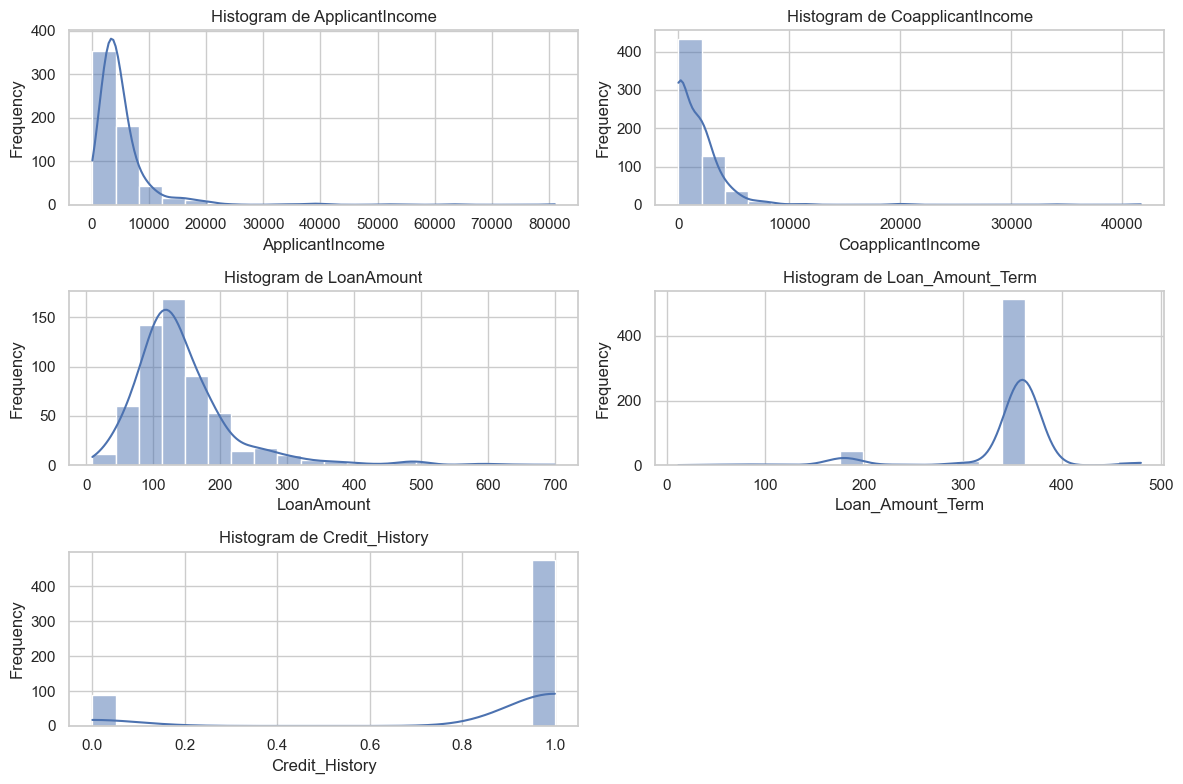

In [32]:
# Histogramas
sns.set(style="whitegrid")

# Lista de columnas numéricas
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# Creamos los histogramas
plt.figure(figsize=(12, 8))
for col in numerical_cols:
    plt.subplot(3, 2, numerical_cols.index(col) + 1)  
    sns.histplot(df[col], bins=20, kde=True)  
    plt.title(f'Histogram de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

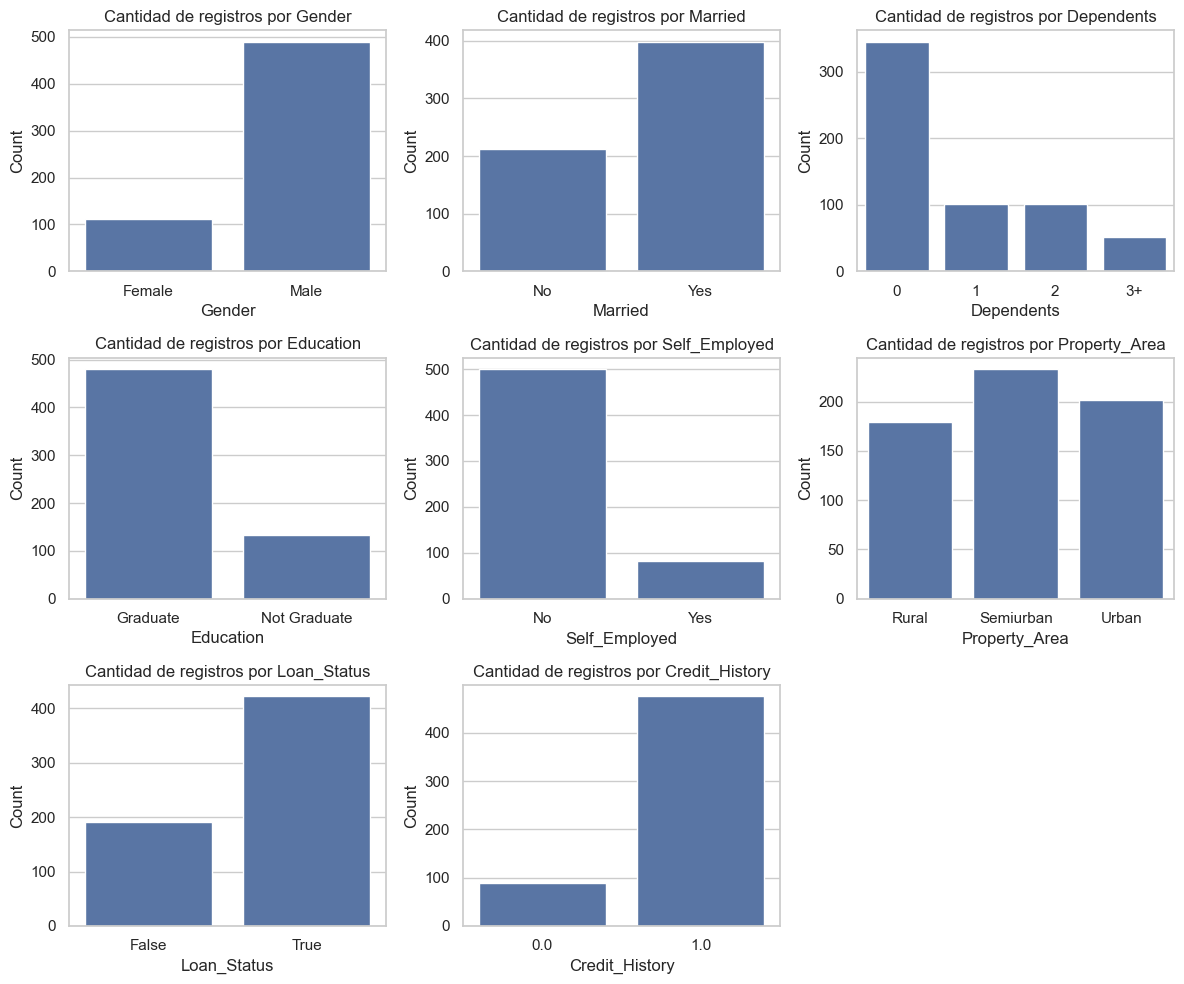

In [33]:
# Create bar plots for categorical columns
plt.figure(figsize=(12, 10))
for col in categorical_cols:
    plt.subplot(3, 3, categorical_cols.index(col) + 1)  
    sns.countplot(data=df, x=col)  
    plt.title(f'Cantidad de registros por {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

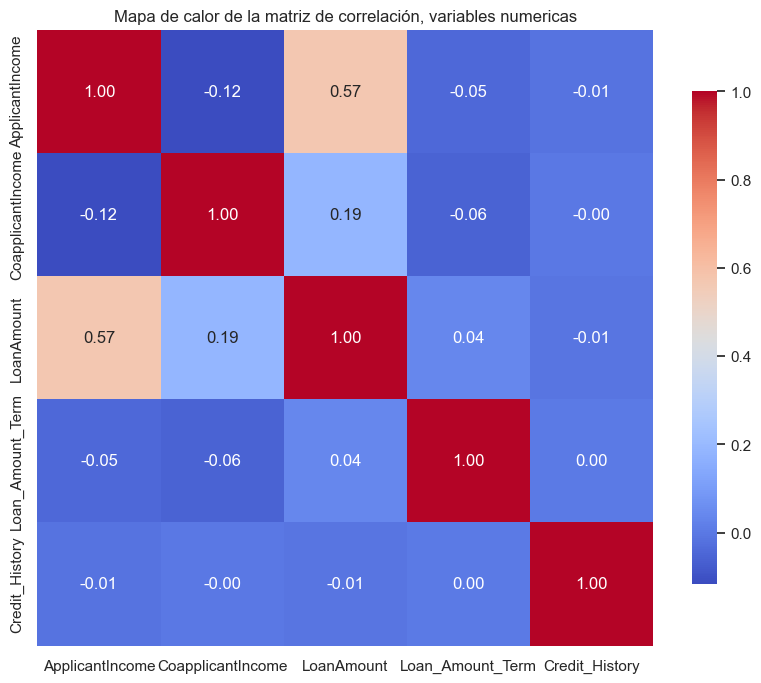

In [34]:
# Calculate correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, fmt=".2f", cbar_kws={"shrink": .8})
plt.title('Mapa de calor de la matriz de correlación, variables numericas')
plt.show()

**3. Valores Faltantes y Outliers:**

* **Detectar y tratar valores faltantes.**
* **Identificar y manejar outliers.**


In [35]:
# Verificamos los valores faltantes
qsna=df.shape[0]-df.isnull().sum(axis=0)
qna=df.isnull().sum(axis=0)
ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
Credit_History,564,50,8.14
Self_Employed,582,32,5.21
LoanAmount,592,22,3.58
Dependents,599,15,2.44
Loan_Amount_Term,600,14,2.28
Gender,601,13,2.12
Married,611,3,0.49
Education,614,0,0.00
Loan_ID,614,0,0.00
CoapplicantIncome,614,0,0.00


In [36]:
# Impute Credit_History
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])

# Impute Self_Employed
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])

# Impute LoanAmount
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())

# Impute Dependents
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])

# Impute Loan_Amount_Term
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median())

# Impute Gender
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])

# Impute Married
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])

# Mostrar los valores faltantes
print(df.isnull().sum())  

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64


## **Parte 3: Preprocesamiento de Datos**

**1.Transformación de Columnas:**

* **Codificar variables categóricas utilizando One-Hot Encoding.**

* **Escalar características numéricas utilizando StandardScaler.**

* **División del Conjunto de Datos:**

* **Dividir el dataset en conjuntos de entrenamiento y prueba.**


In [37]:
# Identificar las columnas categóricas
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']

# Aplicamps One-Hot Encoding
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Iddentificar las columnas numéricas
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# Create a StandardScaler
scaler = StandardScaler()

# Escalar las columnas numéricas
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# Mostrar los datos codificados
print(df_encoded.head())

    Loan_ID  ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
0  LP001002         0.072991          -0.554487   -0.211241          0.273231   
1  LP001003        -0.134412          -0.038732   -0.211241          0.273231   
2  LP001005        -0.393747          -0.554487   -0.948996          0.273231   
3  LP001006        -0.462062           0.251980   -0.306435          0.273231   
4  LP001008         0.097728          -0.554487   -0.056551          0.273231   

   Credit_History  Loan_Status  Gender_Male  Married_Yes  Dependents_1  \
0        0.411733         True         True        False         False   
1        0.411733        False         True         True          True   
2        0.411733         True         True         True         False   
3        0.411733         True         True         True         False   
4        0.411733         True         True        False         False   

   Dependents_2  Dependents_3+  Education_Not Graduate  Self_Employe

In [38]:
# Difinomos las variables
X = df_encoded.drop('Loan_Status', axis=1)  
y = df_encoded['Loan_Status'] 

# Dividimos el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## **Parte 4: Implementación de LightGBM (LGBM)**



**1. Entrenamiento del Modelo:**

* **Entrenar un modelo de LGBM con hiperparámetros básicos.**

* **Evaluar el modelo utilizando métricas de rendimiento como la exactitud, precisión, recall, F1-Score y ROC-AUC.**


In [39]:
# Drop non-numeric columns such as Loan_ID and set target variable
X = df_encoded.drop(['Loan_Status', 'Loan_ID'], axis=1)  # Drop your target variable and any identifiers
y = df_encoded['Loan_Status']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the LightGBM dataset
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Set up the parameters for the model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,  
    'boosting_type': 'gbdt',  
    'learning_rate': 0.1,    
    'num_leaves': 31,        
    'max_depth': -1          
}

# Entrenamos el modelo
num_round = 100  
bst = lgb.train(params, lgb_train, num_round)

# Predicciones
y_pred = bst.predict(X_test)

# Covrertimos las predicciones a 0 o 1
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [40]:
# Evaluamos el modelo
print(f'Accuracy: {accuracy_score(y_test, y_pred_binary)}')
print(classification_report(y_test, y_pred_binary))

Accuracy: 0.7317073170731707
              precision    recall  f1-score   support

       False       0.64      0.53      0.58        43
        True       0.77      0.84      0.80        80

    accuracy                           0.73       123
   macro avg       0.70      0.69      0.69       123
weighted avg       0.72      0.73      0.73       123



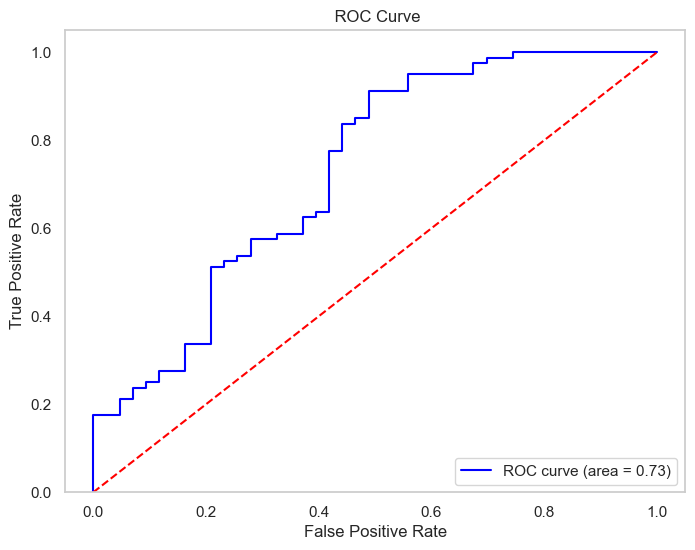

In [51]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
plt.ylim([0.0, 1.05])
plt.title(' ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.show()

**2. Optimización de Hiperparámetros:**

* **Utilizar GridSearchCV para optimizar los hiperparámetros del modelo de LGBM.**
* **Evaluación del Modelo Optimizado:**
* **Evaluar el rendimiento del modelo optimizado y compararlo con el modelo inicial.**

In [48]:
# Set up features and target
X = df_encoded.drop(['Loan_Status', 'Loan_ID'], axis=1)
y = df_encoded['Loan_Status']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: Train the initial model
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1
}

num_round = 100  
lgb_train = lgb.Dataset(X_train, y_train)
bst_initial = lgb.train(params, lgb_train, num_round)

# Predicciones iniciales
y_pred_initial = bst_initial.predict(X_test)
y_pred_initial_binary = [1 if pred >= 0.5 else 0 for pred in y_pred_initial]

# Evaluacio  del modelo
print("Initial Model Evaluation")
print(f'Accuracy: {accuracy_score(y_test, y_pred_initial_binary)}')
print(classification_report(y_test, y_pred_initial_binary))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

In [47]:
# Definimos el grid de hiperparámetros
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [-1, 5, 10, 15],
    'n_estimators': [100, 200, 300]
}

In [ ]:

# Confiuramos GridSearchCV
lgbm = lgb.LGBMClassifier(objective='binary', is_unbalance=True, boosting_type='gbdt')
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)

# Ejecutamos GridSearchCV
grid_search.fit(X_train, y_train)

# Obtenemos el mejor modelo
best_model = grid_search.best_estimator_

# Predicciones optimizadas
y_pred_optimized = best_model.predict(X_test)

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 342, number of negative: 149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 491, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.696538 -> initscore=0.830864
[LightGBM] [Info] Start training from score 0.830864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

c:\Users\damav\Desktop\Codingdojo\clases\machine-learning\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
# Evaluate the optimized model
print("\nOptimized Model Evaluation")
print(f'Accuracy: {accuracy_score(y_test, y_pred_optimized)}')
print(classification_report(y_test, y_pred_optimized))


Optimized Model Evaluation
Accuracy: 0.7398373983739838
              precision    recall  f1-score   support

       False       0.70      0.44      0.54        43
        True       0.75      0.90      0.82        80

    accuracy                           0.74       123
   macro avg       0.73      0.67      0.68       123
weighted avg       0.73      0.74      0.72       123


Initial Hyperparameters: {'objective': 'binary', 'metric': 'binary_logloss', 'is_unbalance': True, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': -1}
Optimized Hyperparameters: {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31}


In [ ]:
# Comparamos con los valores inciales
print("\nInitial Hyperparameters:", params)
print("Optimized Hyperparameters:", grid_search.best_params_)


Initial Hyperparameters: {'objective': 'binary', 'metric': 'binary_logloss', 'is_unbalance': True, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': -1}
Optimized Hyperparameters: {'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31}
